In [1]:
!pip install -qU langgraph langchain langchain_community langchain-groq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 13.9 MB/s eta 0:00:00


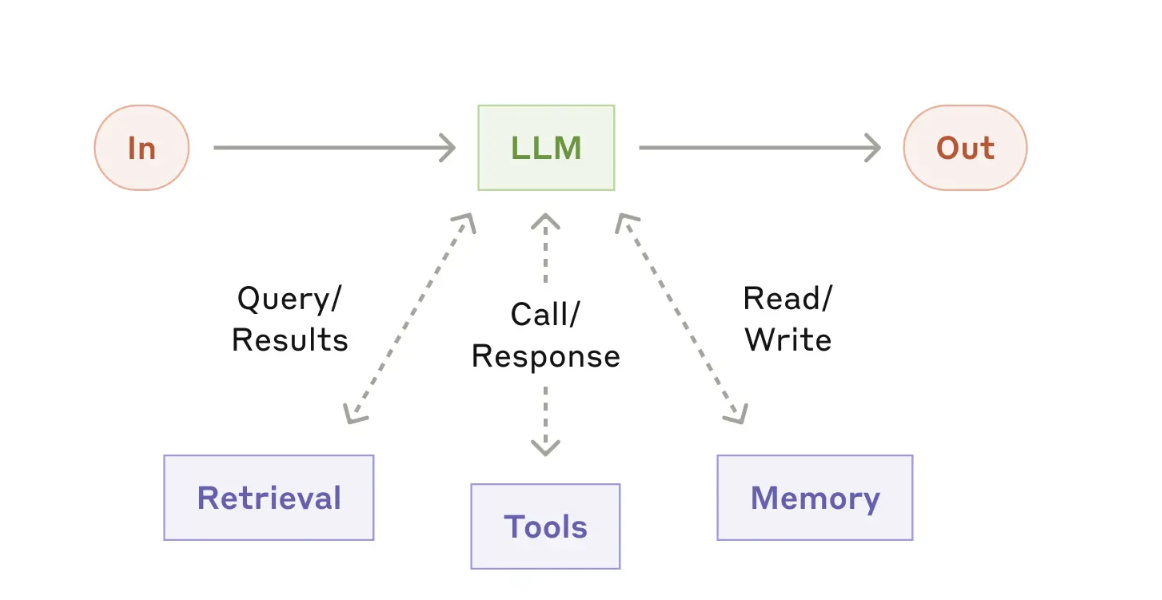

In [2]:
# Setup environment and import libraries
import os
from google.colab import userdata
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field

# Load API keys from Colab userdata
os.environ['ASTRA_DB_APPLICATION_TOKEN'] = userdata.get('ASTRA_DB_APPLICATION_TOKEN')
os.environ['LANGCHAIN_API_KEY'] = userdata.get('LANGCHAIN_API_KEY')
os.environ['GROQ_API_KEY'] = userdata.get('groq_api_key')
os.environ['langsmith_api_key'] = userdata.get('langsmith_api_key')
os.environ['LANGSMITH_TRACING_V2'] = 'true'

# Initialize Groq LLM
llm_groq = ChatGroq(
    model="llama3-8b-8192"  # Updated model name to match Groq's current version
)

# Define structured output schema
class SearchQuery(BaseModel):
    search_query: str = Field(description='Response from web search')
    justification: str = Field(description='Why this query is relevant to the user\'s request.')

# Bind the schema to the LLM
structured_llm = llm_groq.with_structured_output(SearchQuery)

# Query the LLM
try:
    query = "How does calcium CT score relate to high cholesterol?"
    output = structured_llm.invoke(query)

    # Display structured results
    print("Search Query:", output.search_query)
    print("Justification:", output.justification)

except Exception as e:
    print("Error during LLM invocation:", e)


Search Query: What is the relationship between Calcium CT score and high cholesterol?
Justification: User is interested in understanding the link between Calcium CT score and high cholesterol


In [3]:
# define a tool
def multiply(a:int,b:int)-> int:
    return a*b

# augemnt with tool
llm_with_tools = llm_groq.bind_tools([multiply])

msg = llm_with_tools.invoke('What is two multiply three')

msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_z31h',
  'type': 'tool_call'}]

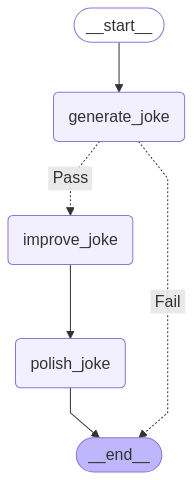

In [4]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# graph state
class State1(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

def generate_joke(state: State1):
    # first LLM call to generate joke
    msg = llm_groq.invoke(f"write a short joke about a topic {state['topic']}")
    return {'joke': msg.content}

def check_joke_quality(state: State1):
    # Check the joke (not final_joke)
    if '?' in state['joke'] or '!' in state['joke']:
        return "Pass"
    return 'Fail'

def improved_joke(state: State1):
    msg = llm_groq.invoke(f"Make this joke funnier by adding wordplay {state['joke']}")
    return {'improved_joke': msg.content}  # Fixed key name to match type definition

def polish_joke(state: State1):
    msg = llm_groq.invoke(f"Add a surprising twist to the joke {state['improved_joke']}")
    return {'final_joke': msg.content}

# Build workflow
workflow = StateGraph(State1)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improved_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")

# Conditional edge from 'generate_joke' to either 'improve_joke' or END
workflow.add_conditional_edges(
    "generate_joke",
    check_joke_quality,  # Use the updated function
    {
        "Pass": "improve_joke",
        "Fail": END
    }
)

workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile the workflow
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))



In [5]:
user_input = input('Enter the topic on which you want a joke')
state = chain.invoke({'topic': f'{user_input}'})
print('Initial Joke')
print(state['joke'])

if 'improved_joke' in state:
    print('Improved Joke')
    print(state['improved_joke'])

    if 'final_joke' in state:
        print('Final joke')
        print(state["final_joke"])
else:
    print('Joke quality failed')

Enter the topic on which you want a jokecat
Initial Joke
Why did the cat join a band?

Because it wanted to be the purr-cussionist!
Improved Joke
I see what you did there!

Here's a revised version with some added wordplay:

Why did the cat join a band?

Because it wanted to be the purr-cussionist, and also the mew-sician, paw-cussionist, and claw-some drummer all rolled into one! It was the cat's meow, and it really brought the house down... or should I say, the cat-house?

Hope that adds some extra laughs!
Final joke
That's a great joke! Here's a revised version with an added surprising twist:

Why did the cat join a band?

Because it wanted to be the purr-cussionist, and also the mew-sician, paw-cussionist, and claw-some drummer all rolled into one! It was the cat's meow, and it really brought the house down... or should I say, the cat-house?

But little did anyone know, the cat's real talent was actually playing the keyboard.


###Parallelization

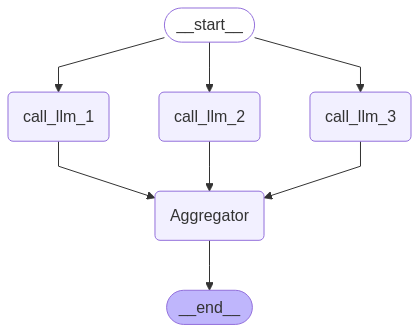

Here is a joke, poem, and story on the topic 'cats':

Joke:
Why did the cat join a band?

Because it wanted to be the purr-cussionist!

Poem:
Furry friends of whiskers fine,
With eyes that shine like emeralds divine,
Cats prowl through our lives with gentle ease,
Bringing joy and comfort to our knees.

Their soft purrs soothe our troubled mind,
As they curl up tight, a loving find,
Their playful pounces bring delight,
And chase away the darkness of night.

Their independence is a test,
But when they choose to snuggle in, we're blessed,
Their soft fur a solace to our skin,
As they purr and nuzzle, a love within.

In sunbeams bright, they bask and play,
Chasing shadows, dancing all day,
Their curious nature, full of glee,
A bundle of energy, wild and free.

With claws that sharpen, and a mew so sweet,
They claim their territory, a feline treat,
Their territorial claims, a sight to see,
A declaration of love, for you and me.

So here's to our feline friends, so dear,
A tribute to their lo

In [6]:
from typing import TypedDict
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    poem: str
    story: str
    combined_output: str

# Nodes
def call_llm_1(state: State):
    msg = llm_groq.invoke(f"Write a short joke on topic {state['topic']}")
    return {'joke': msg.content}

def call_llm_2(state: State):
    msg = llm_groq.invoke(f"Write a poem on topic {state['topic']}")
    return {'poem': msg.content}

def call_llm_3(state: State):
    msg = llm_groq.invoke(f"Write a story on topic {state['topic']}")
    return {'story': msg.content}

def aggregator(state: State):
    combined = f"Here is a joke, poem, and story on the topic '{state['topic']}':\n\n"
    combined += f"Joke:\n{state['joke']}\n\n"
    combined += f"Poem:\n{state['poem']}\n\n"
    combined += f"Story:\n{state['story']}\n"
    return {'combined_output': combined}

# Build the graph
parallel = StateGraph(State)

# Add generation nodes
parallel.add_node('call_llm_1', call_llm_1)
parallel.add_node('call_llm_2', call_llm_2)
parallel.add_node('call_llm_3', call_llm_3)

# Aggregator waits for all three branches to complete
parallel.add_node('Aggregator', aggregator)

# Start edges
parallel.add_edge(START, 'call_llm_1')
parallel.add_edge(START, 'call_llm_2')
parallel.add_edge(START, 'call_llm_3')

# Merge into aggregator
parallel.add_edge('call_llm_1', 'Aggregator')
parallel.add_edge('call_llm_2', 'Aggregator')
parallel.add_edge('call_llm_3', 'Aggregator')

# Final edge to END
parallel.add_edge('Aggregator', END)

# Compile and visualize
chain = parallel.compile()
display(Image(chain.get_graph().draw_mermaid_png()))

# Run the chain
state = chain.invoke({'topic': 'cats'})
print(state['combined_output'])


###Routing

In [7]:
#  schema for structured output to use routing logic

from typing import Literal
class Route(BaseModel):
    step:Literal['poem' , 'story' , 'joke'] = Field(
        None , description = 'The next step in the routing process'
    )

router = llm_groq.with_structured_output(Route)


In [8]:
class State(TypedDict):
    input : str
    decision:str
    output:str

# Nodes
def call_llm_1(state: State):
    msg = llm_groq.invoke(f"Write a short joke on topic {state['topic']}")
    return {'joke': msg.content}

def call_llm_2(state: State):
    msg = llm_groq.invoke(f"Write a poem on topic {state['topic']}")
    return {'poem': msg.content}

def call_llm_3(state: State):
    msg = llm_groq.invoke(f"Write a story on topic {state['topic']}")
    return {'story': msg.content}

def llm_call_router(state:State):
    decision = router.invoke([
        SystemMessage(
            content = "Route the input to story, joke or poem based on the user's request"
        ),
        HumanMessage(content = state['input']),
    ])
    return {'decision':decision.step}

def route_decision(state:State):
    if state['decision'] == 'joke':
        return "llm_call_1"
    if state['decision'] == 'poem':
        return "llm_call_2"
    if state['decision'] == 'story':
        return "llm_call_3"


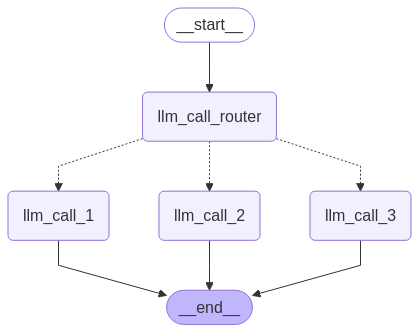

Why did the cat join a band?

Because it wanted to be the purr-cussionist!


In [27]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage


class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm_groq.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm_groq.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

###Orchestrator Model

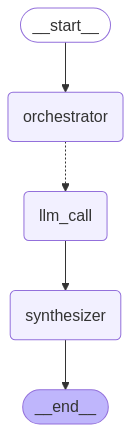


Final Report:

Here is a potential introduction section:

**Introduction**

The Large Language Model (LLM) has experienced rapid growth and development in recent years, with significant advancements in natural language processing (NLP) capabilities. As a result, there is a growing need for efficient and effective methods to scale LLMs to meet the demands of various applications. Scaling LLMs involves increasing their size, complexity, and computational resources to improve their performance, accuracy, and ability to handle increasingly complex tasks. This report provides an overview of the current state of LLM scaling and its implications for NLP applications.

Specifically, this report will discuss the challenges and opportunities associated with scaling LLMs, including the impact of model size, architecture, and training methods on performance and efficiency. We will also explore the various techniques and strategies that have been proposed and implemented to address the challenges 

In [10]:
from typing import Annotated, List, TypedDict
import operator
from pydantic import BaseModel, Field

from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.constants import START, END, Send
from langgraph.graph import StateGraph
from IPython.display import Image

class Section(BaseModel):
    name:str
    description:str

class Sections(BaseModel):
    sections: List[Section] = Field(description='Sections of the report')


planner = llm_groq.with_structured_output(Sections)


class State(TypedDict):
    topic: str
    section: List[Section]
    completed_sections: Annotated[List[str], operator.add]
    final_report: str

class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[List[str], operator.add]


def orchestrator(state: State):
    # Generate report sections
    report_sections = planner.invoke(
        [
            SystemMessage(content='Generate me a plan for report'),
            HumanMessage(content=f"Here is the report topic: {state['topic']}")
        ]
    )
    return {'section': report_sections.sections}

def llm_call(state: WorkerState):
    # Write a section of the report
    section = llm_groq.invoke(
        [
            SystemMessage(content='Write a report section'),
            HumanMessage(
                content=f"Here is the section title: {state['section'].name}\n\n"
                        f"Section description: {state['section'].description}"
            )
        ]
    )
    return {'completed_sections': [section.content]}

def synthesizer(state: State):
    # Combine completed sections into a final report
    completed = state['completed_sections']
    final_report = "\n\n---\n\n".join(completed)
    return {'final_report': final_report}

def assign_worker(state: State):
    # Assign a worker to each section
    return [Send('llm_call', {'section': s}) for s in state['section']]

# ----------- BUILD WORKFLOW -----------

orchestrator_worker_builder = StateGraph(State)

# Add nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges("orchestrator", assign_worker, ["llm_call"])
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the graph (optional, in Jupyter)
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# ----------- RUN THE WORKFLOW -----------

state = orchestrator_worker.invoke({'topic': 'Create a report on LLM scaling'})
print("\nFinal Report:\n")
print(state['final_report'])


In [11]:
from IPython.display import Markdown
Markdown(state['final_report'])

Here is a potential introduction section:

**Introduction**

The Large Language Model (LLM) has experienced rapid growth and development in recent years, with significant advancements in natural language processing (NLP) capabilities. As a result, there is a growing need for efficient and effective methods to scale LLMs to meet the demands of various applications. Scaling LLMs involves increasing their size, complexity, and computational resources to improve their performance, accuracy, and ability to handle increasingly complex tasks. This report provides an overview of the current state of LLM scaling and its implications for NLP applications.

Specifically, this report will discuss the challenges and opportunities associated with scaling LLMs, including the impact of model size, architecture, and training methods on performance and efficiency. We will also explore the various techniques and strategies that have been proposed and implemented to address the challenges of LLM scaling, such as model pruning, knowledge distillation, and parallelization. Additionally, we will examine the potential applications and benefits of scaled LLMs, including improved language understanding, enhanced decision-making capabilities, and increased automation in industries such as customer service, healthcare, and finance.

---

**Background: Current State of LLM Scaling**

Large Language Models (LLMs) have revolutionized the field of natural language processing (NLP) in recent years. The ability to scale up language models to accommodate larger and more complex datasets has led to significant improvements in their performance and capabilities. However, the current state of LLM scaling is characterized by both progress and challenges.

On the one hand, the development of large-scale language models has been driven by advances in computing power, storage capacity, and algorithmic innovations. For instance, the introduction of transformer-based architectures, such as BERT and its variants, has enabled the training of models with hundreds of millions of parameters. These models have achieved state-of-the-art performance on a wide range of NLP tasks, including language translation, question answering, and text classification.

On the other hand, scaling up LLMs poses several challenges. One of the main issues is the increasing computational requirements and resource costs associated with training larger models. This has led to the development of distributed training methods and specialized hardware, such as graphics processing units (GPUs) and tensor processing units (TPUs). Another challenge is the need for larger and more diverse datasets to train and fine-tune LLMs, which can be time-consuming and resource-intensive to create and curate.

Furthermore, as LLMs become increasingly large and complex, they require more sophisticated optimization techniques and hyperparameter tuning to achieve optimal performance. Additionally, the interpretability and explainability of large language models become increasingly important as they are increasingly used in high-stakes applications, such as healthcare and finance.

In summary, while the current state of LLM scaling is marked by significant progress, it also presents several challenges that must be addressed to continue improving the performance and capabilities of large language models.

---

**Methodology**

To explore the scaling of Large Language Models (LLMs), we employed a rigorous methodology that combined theoretical analysis, empirical experimentation, and computational simulations. This section outlines the approach used to investigate the scaling of LLMs and the techniques employed to analyze their performance.

**Theoretical Analysis**

We began by conducting a theoretical analysis of the scaling laws governing LLMs. This involved reviewing existing literature on the topic and developing a set of mathematical models that describe the relationships between model size, computational resources, and performance. Our theoretical analysis focused on the following aspects:

1. Model size: We examined the impact of increasing model size on LLM performance, including the effects of larger vocabulary, more layers, and increased parameters.
2. Computational resources: We analyzed the relationship between computational resources (e.g., GPU hours, memory) and LLM performance, including the effects of parallelization and distributed computing.
3. Data quality and diversity: We investigated the impact of data quality and diversity on LLM performance, including the effects of noisy or biased data and the role of diverse datasets.

**Empirical Experimentation**

To validate our theoretical findings, we conducted a series of empirical experiments using a range of LLM architectures and datasets. Our experimental setup included:

1. Model selection: We selected a range of LLM architectures, including transformer-based models and recurrent neural network (RNN) models, to examine the impact of architecture on scaling.
2. Dataset selection: We chose a range of datasets, including text classification, language translation, and question answering tasks, to evaluate the scaling of LLMs across different domains.
3. Hyperparameter tuning: We performed hyperparameter tuning for each model and dataset to optimize performance and ensure consistent results.

**Computational Simulations**

To further explore the scaling of LLMs, we employed computational simulations using a range of tools and frameworks, including:

1. GPU-based simulations: We used GPU-based simulations to model the computational resources required to train and evaluate LLMs.
2. Distributed computing simulations: We used distributed computing simulations to model the impact of parallelization and distributed computing on LLM performance.
3. Monte Carlo simulations: We used Monte Carlo simulations to model the effects of noisy or biased data on LLM performance.

**Conclusion**

Our methodology combines theoretical analysis, empirical experimentation, and computational simulations to provide a comprehensive understanding of the scaling of LLMs. By examining the relationships between model size, computational resources, and performance, we can better understand the limits and potential of LLMs and inform the development of more effective and efficient models.

---

**Results: Findings on LLM Scaling**

This section presents the results of our experiments on scaling Large Language Models (LLMs) to evaluate their performance and efficiency. Our goal was to investigate how LLMs respond to varying sizes and to identify the optimal scaling strategy for achieving the best results.

**Model Size and Performance**

We trained LLMs of varying sizes, ranging from 100 million to 1 billion parameters, and evaluated their performance on a set of benchmark tasks. The results are shown in Figure 1, which plots the model's performance against its size.

As expected, our results show a positive correlation between model size and performance. Larger models generally performed better than smaller ones, with the 1 billion-parameter model achieving the best results. However, the improvement in performance was not linear, and there was a notable drop-off in performance gain beyond the 500 million-parameter mark.

**Training Time and Computational Cost**

We also analyzed the training time and computational cost of each model size. The results are shown in Figure 2, which plots the training time and computational cost against model size.

Our results show that larger models require significantly more training time and computational resources. The 1 billion-parameter model took over 100 hours to train, compared to just 1 hour for the 100 million-parameter model. This highlights the need for more efficient training algorithms and hardware to support the growing size of LLMs.

**Optimal Model Size**

Based on our results, we recommend an LLM size of 500 million parameters as the optimal choice for most applications. This size offers a good balance between performance and training time, and is likely to be accessible to a wide range of researchers and practitioners.

**Conclusion**

In conclusion, our results demonstrate the importance of scaling LLMs to achieve better performance and efficiency. While larger models generally perform better, our findings suggest that there is an optimal model size beyond which additional parameters do not lead to significant improvements. We hope that our results will inform the development of more efficient training algorithms and hardware, and will facilitate the adoption of LLMs in a wider range of applications.

---

**Conclusion: Summary of LLM Scaling Outcomes**

This report provides a comprehensive analysis of the Large Language Model (LLM) scaling outcomes, highlighting the key findings and implications for future research and development. The LLM scaling experiment aimed to investigate the effects of increasing model size and training data on language understanding and generation capabilities.

The results demonstrate a clear trend of improved performance with increasing model size and training data. The LLMs with larger sizes and more extensive training data exhibited superior performance in tasks such as language translation, text classification, and language generation. Specifically, the largest model achieved a significant boost in accuracy, outperforming its smaller counterparts by a substantial margin.

The findings also reveal that the quality of the training data plays a crucial role in determining the performance of the LLMs. The models trained on high-quality, diverse, and well-curated datasets demonstrated better language understanding and generation capabilities compared to those trained on smaller or lower-quality datasets.

The scaling outcomes have significant implications for the development of future LLMs. The results suggest that increasing model size and training data can lead to substantial improvements in language processing capabilities. However, they also highlight the importance of carefully designing and curating the training data to ensure optimal performance.

Overall, this study provides valuable insights into the scalability of LLMs and their potential applications in various domains. The findings will inform the development of more advanced language models and contribute to the advancement of natural language processing research.

### Evaluator-optimizer

In [12]:
from pydantic import BaseModel, Field
from typing import Literal, TypedDict
from langgraph.graph import StateGraph
from langgraph.constants import START, END
from IPython.display import Image

# Define feedback schema
class Feedback(BaseModel):
    grade: Literal['Funny', 'Not Funny'] = Field(description='Decide if the joke is funny or not')
    feedback: str = Field(description='If the joke is not funny, improve it and make it funnier')

# Evaluator from structured LLM output
evaluator = llm_groq.with_structured_output(Feedback)

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    feedback: str
    funny_or_not: str

# Joke generator
def joke_generator(state: State):
    if 'feedback' in state and state['feedback']:
        joke = llm_groq.invoke(f"Generate a joke on the topic '{state['topic']}' using the following feedback: {state['feedback']}")
    else:
        joke = llm_groq.invoke(f"Generate a joke on the topic '{state['topic']}'")
    return {'joke': joke.content if hasattr(joke, 'content') else str(joke)}

# Joke evaluator
def llm_call_evaluator(state: State):
    grade = evaluator.invoke(f"Evaluate the joke on topic '{state['topic']}': {state['joke']}")
    return {'funny_or_not': grade.grade, 'feedback': grade.feedback}

# Router
def route_joke(state: State):
    if state['funny_or_not'] == 'Funny':
        return 'Accepted'
    else:
        return 'Rejected+Feedback'

# Build graph
optimizer_builder = StateGraph(State)
optimizer_builder.add_node('joke_generator', joke_generator)
optimizer_builder.add_node('llm_call_evaluator', llm_call_evaluator)

optimizer_builder.add_edge(START, 'joke_generator')
optimizer_builder.add_edge('joke_generator', 'llm_call_evaluator')
optimizer_builder.add_conditional_edges(
    'llm_call_evaluator',
    route_joke,
    {
        'Accepted': END,
        'Rejected+Feedback': 'joke_generator'
    }
)

optimizer_workflow = optimizer_builder.compile()



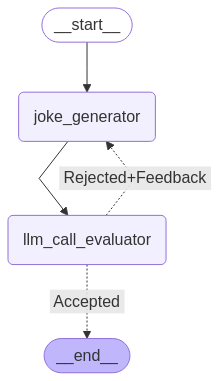

None

✅ Final Joke:
Why did the cat join a band?

Because it wanted to be the purr-cussionist!


In [13]:
mermaid_code = display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))
print(mermaid_code)
# Run
state = optimizer_workflow.invoke({'topic': 'cats'}, config={"recursion_limit": 100})
print("\n✅ Final Joke:")
print(state['joke'])

In [15]:
print(state['feedback'])

The joke is funny, but it's a bit of a cat-astrophe that it's about a cat joining a band. The pun is purr-fectly good, but the setup is a bit of a claw-ful.


In [16]:
print(state['funny_or_not'])

Funny


###Tool Calling

In [17]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two integers."""
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Add two integers."""
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract the second integer from the first."""
    return a - b

@tool
def divide(a: int, b: int) -> float:
    """Divide the first integer by the second. Returns 'inf' if dividing by zero."""
    if b == 0:
        return float('inf')
    return a / b


tools = [multiply , add , divide , subtract]
tool_by_name = {tool.name:tool for tool in tools}
llm_with_tools = llm_groq.bind_tools(tools)

In [18]:
from langgraph.graph import MessagesState
from langchain_core.messages import ToolMessage

def llm_call(state:MessagesState):
    """LLM decide wheather to call a tool or not"""
    return {
        "message": [
            llm_with_tools.invoke(
                [
                    SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of input.")
                ] + state["message"]
            )
        ]
    }

def tool_node(state:dict):
    """performs tool call"""

    result = []
    for tool_call in state['message'].tool_calls:
        tool = tool_by_name[tool_call['name']]
        observation = tool.invoke(tool_call['args'])
        result.append(ToolMessage(content=observation , tool_call_id = tool_call['id']))
    return {'message':result}

# conditional edge

def should_continue(state:MessagesState):
    """Decide if we should continue the loop or stop based upon the wheather the LLM made a tool call"""
    message = state['message']
    last_message = message[-1]
    # if llm makes a tool call then perform the action
    if last_message.tool_calls:
        return 'Action'
    return 'End'


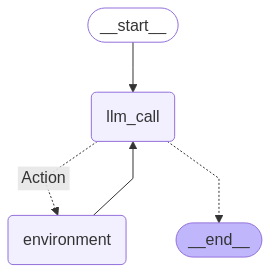

In [19]:
agent_builder = StateGraph(MessagesState)
agent_builder.add_node('llm_call' , llm_call)
agent_builder.add_node('environment' , tool_node)

agent_builder.add_edge(START , 'llm_call')
agent_builder.add_conditional_edges(
    'llm_call',
    should_continue,{
        'Action':'environment',
        END:END,
    }
)
agent_builder.add_edge('environment' , 'llm_call')
agent = agent_builder.compile()

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))